# <span style="color:red">QPM: Assignment 3</span>

###  LAFTIT Mehdi, LIN Christine, MUSEUX Célia and YANG Hexuan 

Financial Engineering - Quantitative Portfolio Management

**Due date :** 10/11/2023 9am

**Ressource:** Tidy finance website / Danny Groves

> *Please run the code cell by cell to make it works*

## <span style="color:green">Preliminary step</span>

We import the libraries we are going to use in this assigment:

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tabulate import tabulate
import scipy.stats as stats

C:\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## <span style="color:green">Question 1 of Assignment 3</span>

The goal of the question is to prepare the data for this assignment

### 1.1 Extract the list of ticker symbols from Wikipedia

The URL in the code below is the Wikipedia page which has the up-to-date list of S&P500 stocks. By using the pd.read_html() functionality we can let pandas do the hard work for us (without context, saying “let pandas do the hard work for us” sounds bad). Since there are two tables of information on this webpage, we must use the index position of 0 to obtain the list we desire.

In [2]:
url = ("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
symbols = pd.read_html(url)[0]['Symbol'].tolist()

We ran the code a first time and noticed that 4 tickers fails to be downloaded (errors). So we have decided to ignore them.

In [3]:
tickers_to_remove = ['BRK.B', 'BF.B', 'KVUE', 'VLTO']
symbols = [ticker for ticker in symbols if ticker not in tickers_to_remove]

### 1.2 Build a dataframe with the prices for the SP500 companies

Now, we can download the prices from Yahoo Finance

In [4]:
SP500_prices = (yf.download(tickers=symbols, 
                            start="2000-01-01",
                            end="2022-12-31",
                            progress=False)
  .melt(ignore_index=False, 
        var_name=["variable", "symbol"])
  .reset_index()
  .pivot(index=["Date", "symbol"], 
         columns="variable", 
         values="value")
  .reset_index()
  .rename(columns = {"Date": "date", 
                     "Open": "open", 
                     "High": "high", 
                     "Low": "low",
                     "Close": "close", 
                     "Adj Close": "adjusted", 
                     "Volume": "volume"
                    })
)

In [5]:
SP500_prices.head()

variable,date,symbol,adjusted,close,high,low,open,volume
0,2000-01-03,A,43.757755,51.502148,56.464592,48.193848,56.330471,4674353.0
1,2000-01-03,AAL,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,AAPL,0.848323,0.999442,1.004464,0.907924,0.936384,535796800.0
3,2000-01-03,ABBV,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-03,ABNB,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3 Clean the data

We drop the columns that have only “NaN” entries. We drop also the company names that have more than 100 missing observations.

In [1]:
SP500_prices = SP500_prices.dropna(axis=1, how='all')

threshold = 100

# We count the number of missing values for each symbol
missing_counts = SP500_prices.groupby('symbol').apply(lambda x: x.isnull().sum()).sum(axis=1)
valid_symbols = missing_counts[missing_counts <= threshold].index

# We keep the symbols with fewer than 100 missing observations
new_SP500_prices = SP500_prices[SP500_prices['symbol'].isin(valid_symbols)]
new_SP500_prices.reset_index(drop=True, inplace=True)

NameError: name 'SP500_prices' is not defined

We can plot the first 10 tickers' prices of the SP500

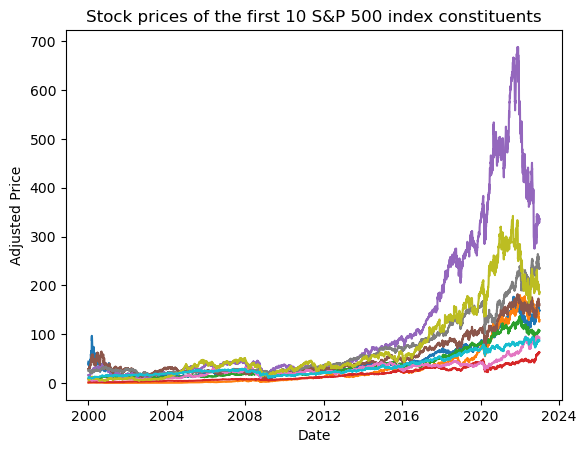

In [7]:
symbols_to_plot = new_SP500_prices['symbol'].unique()[:10]
filtered_data = new_SP500_prices[new_SP500_prices['symbol'].isin(symbols_to_plot)]

fig, ax = plt.subplots()
for symbol, data in filtered_data.groupby('symbol'):
    ax.plot(data['date'], data['adjusted'], label=symbol)

ax.set_title("Stock prices of the first 10 S&P 500 index constituents")
ax.set_xlabel("Date")
ax.set_ylabel("Adjusted Price")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.legend().set_visible(False)

plt.show()

Now the data are cleaned and ready to be used

## <span style="color:green">Question 2 of Assignment 3</span>

We now have to compute the log returns for the companies in our dataset. The formula to compute the log return is:  $ln(Pt/P(t-1))$ where $ln$ is the natural logarithm function and $Pt$ is the adjusted prices at time t.


In [8]:
all_returns = (new_SP500_prices
  .assign(log_ret = lambda x: x.groupby("symbol", group_keys=False)["adjusted"].apply(lambda x: np.log(x/(x.shift(1)))))
  .get(["symbol", "date", "log_ret"])
  .dropna(subset="log_ret")
)

In [9]:
all_returns

variable,symbol,date,log_ret
360,A,2000-01-04,-0.079464
361,AAPL,2000-01-04,-0.088078
362,ABT,2000-01-04,-0.028987
363,ACGL,2000-01-04,-0.005450
364,ADBE,2000-01-04,-0.087618
...,...,...,...
2083315,XOM,2022-12-30,0.010023
2083316,XRAY,2022-12-30,-0.013724
2083317,YUM,2022-12-30,-0.014803
2083318,ZBRA,2022-12-30,-0.004358


We create a plot to visualize the log returns for the first 10 tickers:

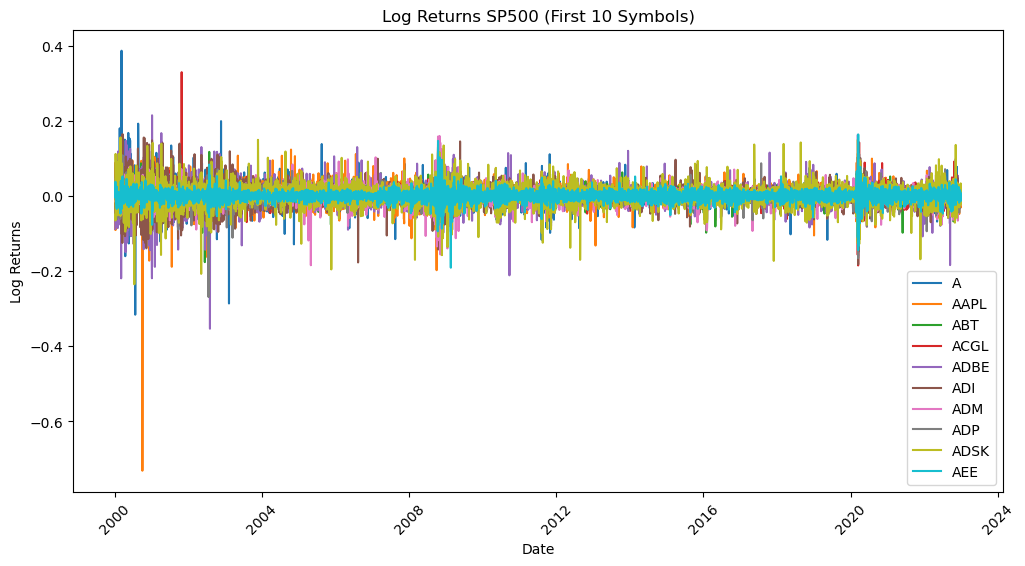

In [10]:
symbols = all_returns['symbol'].unique()[:10] 

fig, ax = plt.subplots(figsize=(12, 6))
for symbol in symbols:
    subset = all_returns[all_returns['symbol'] == symbol]
    ax.plot(subset['date'], subset['log_ret'], label=symbol)
ax.set_xlabel('Date')
ax.set_ylabel('Log Returns')
ax.set_title('Log Returns SP500 (First 10 Symbols)')
ax.legend(loc='best')
plt.xticks(rotation=45)

plt.show()

## <span style="color:green">Question 3 of Assignment 3</span>

We can now compute the annual mean return, annual volatility, and Sharpe ratios for these companies in our dataset. We consider that in a year, there are 252 business days.

The Sharpe ratio (SR) is a measure of the risk-return tradeoff: it is the mean return in excess of the risk-free rate divided by the volatility of returns.

We use the yield on a 10-year Treasury Bond as proxy for the risk free rate, which is around 2% (in average).

In [11]:
annualized_returns = all_returns.groupby('symbol')['log_ret'].mean() * 252  
annualized_volatility = all_returns.groupby('symbol')['log_ret'].std() * np.sqrt(252)

risk_free_rate = 0.02
sharpe_ratios = (annualized_returns - risk_free_rate) / annualized_volatility


results = pd.DataFrame({
    'Company': annualized_returns.index,
    'Annualized Return': annualized_returns.values,
    'Annualized Volatility': annualized_volatility.values,
    'Sharpe Ratio': sharpe_ratios.values
})

results = results.sort_values(by='Sharpe Ratio', ascending=False)

table = tabulate(results, headers='keys', tablefmt='pretty', showindex=False)
print(table)

+---------+-----------------------+-----------------------+------------------------+
| Company |   Annualized Return   | Annualized Volatility |      Sharpe Ratio      |
+---------+-----------------------+-----------------------+------------------------+
|  MNST   |  0.3061819476335931   |  0.4518954129604336   |   0.6332924376434202   |
|   AZO   |  0.19122783848244995  |  0.2837366355978143   |   0.6034745499878231   |
|  TSCO   |  0.24269036308163025  |  0.37007149220583524  |   0.6017495748031545   |
|   WRB   |  0.17644051330866714  |  0.26840652518869107  |   0.5828491434725319   |
|   UNH   |  0.19894457847327746  |  0.3126331849372804   |   0.5723787080030447   |
|   NEE   |  0.15349583865713953  |  0.23524731247715686  |   0.567470196583446    |
|   SRE   |  0.16453296249961347  |  0.25573936071967907  |   0.5651572839350252   |
|  ACGL   |  0.16961933926711353  |  0.26536385788398537  |   0.5638271182073549   |
|   LMT   |  0.16364379660895778  |  0.25486791954137294  |   0.5

**Interpretation**: Here we have decided to rank the tickers according to their Sharpe Ratio (the first ticker has the highest SR).

A higher Sharpe Ratio indicates a better risk-adjusted return, which means that the investment is generating more return for each unit of risk taken. Investors typically prefer investments or portfolios with higher Sharpe Ratios, as they offer better compensation for the level of risk involved.
A negative Sharpe Ratio indicates that an investment has underperformed a risk-free investment or has not provided sufficient compensation for the level of risk taken. 

## <span style="color:green">Question 4 of Assignment 3</span>

Here the question is to know if it would make sense to choose portfolio weights based *ONLY* on the Sharpe ratios of the stocks in our dataset.

The Sharpe Ratio is the main performance measure but have limitations:
- It is not appropriate for individual assets because it ignores correlation between these assets.
- It is not appropriate if returns have high skewness and kurtosis because it depends on the mean and variance of returns
- It looks at first two moments, but ignores the distribution of returns. 


Thus, a best strategy to choose portfolio weights is based on Sharpe Ratio and other factors:
-  Consider correlation between assets, since a high correlation can increase risk and require careful weight allocation
-  Consider transaction costs and management fees associated with the assets in the portfolio since high costs can erode returns
-  Consider risk tolerance and investment objectives of the investor. Invetsor with a higher risk tolerance may seek higher returns, even if it comes with increased volatility.
-  Consider diversification across different asset classes, industries, or geographic regions. 
- Consider economic and market conditions since changes in these conditions can significantly impact asset performance and making them less adaptive to market fluctuations.


   In summary, choosing portfolio weights based solely on Sharpe Ratios is limited because it ignores asset correlations, skewness, kurtosis, and distribution of returns. A more robust strategy considers factors like asset correlations, transaction costs, risk tolerance, diversification, and other relevant factors to create a well-balanced and risk-optimized investment portfolio.

*To go a step further and support the second point of question 4, we can calculate the skewness and kurtosis of the returns*

In [12]:
skewness_list = []
kurtosis_list = []

for symbol in all_returns['symbol'].unique():
    returns = all_returns[all_returns['symbol'] == symbol]['log_ret']
    skewness = stats.skew(returns)
    kurtosis = stats.kurtosis(returns)
    
    skewness_list.append(skewness)
    kurtosis_list.append(kurtosis)


skew_kurt_df = pd.DataFrame({
    'Symbol': all_returns['symbol'].unique(),
    'Skewness': skewness_list,
    'Kurtosis': kurtosis_list
})

skew_kurt_table = tabulate(skew_kurt_df, headers='keys', tablefmt='pretty', showindex=False)
print(skew_kurt_table)

+--------+------------------------+--------------------+
| Symbol |        Skewness        |      Kurtosis      |
+--------+------------------------+--------------------+
|   A    |  0.19474156947841748   | 19.643510444486537 |
|  AAPL  |   -3.986144111006018   | 111.38682546256287 |
|  ABT   |  -0.4203070132422567   | 8.373430230013968  |
|  ACGL  |   0.954435994916369    |  35.3822570892966  |
|  ADBE  |  -0.5400630610982347   | 12.557258155256882 |
|  ADI   |  0.15286337671666922   | 5.696938067137497  |
|  ADM   |  -0.3876703145174366   | 9.528022137716615  |
|  ADP   |  -1.0071155816966726   | 21.065134982458762 |
|  ADSK  |  -0.33524926938347915  | 7.071644396021311  |
|  AEE   |  -0.5543104996776446   | 19.859898075937167 |
|  AEP   |  -0.49270076257409123  | 24.247462943942942 |
|  AES   |  -1.8691208893723406   | 52.533449711669576 |
|  AFL   |  -1.2446535925920195   | 45.59131439998089  |
|  AIG   |  -3.2660049713793518   | 116.55543185791585 |
|  AJG   |  -0.4730378603001302

*We can see that some stocks have very high kurtosis, such as AAPL (kurtosis: 111) or AIG (skewness: -3, kurtosis: 116). In these cases, considering only the Sharpe Ratio is limited.*

## <span style="color:green">Final step</span>

We are finally asked to save the data we have downloaded for a future use.

In [13]:
file_path = "Log_returns_SP500.csv"
all_returns.to_csv(file_path, index=False)

print(f"Data saved to {file_path}")

Data saved to Log_returns_SP500.csv


In [14]:
file_path = "Mean_Volatility_SR_SP500.csv"
results.to_csv(file_path, index=False)

print(f"Data saved to {file_path}")

Data saved to Mean_Volatility_SR_SP500.csv


In [8]:
file_path = "New_SP500_prices.csv"
new_SP500_prices.to_csv(file_path, index=False)

print(f"Data saved to {file_path}")

Data saved to New_SP500_prices.csv
